<a href="https://colab.research.google.com/github/IssamBenamara/SIFT_BOW/blob/master/REDS_Data_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visualisation

_Ismaël Bonneau & Issam Benamara_

In [0]:
!wget https://github.com/ismaelbonneau/REDS/raw/master/data/training.csv

--2019-10-16 21:33:39--  https://github.com/ismaelbonneau/REDS/raw/master/data/training.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ismaelbonneau/REDS/master/data/training.csv [following]
--2019-10-16 21:33:40--  https://raw.githubusercontent.com/ismaelbonneau/REDS/master/data/training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55253673 (53M) [text/plain]
Saving to: ‘training.csv’

training.csv        100%[===================>]  52.69M  84.0MB/s    in 0.6s    

2019-10-16 21:33:44 (84.0 MB/s) - ‘training.csv’ saved [55253673/55253673]



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

np.random.seed(42)

In [0]:
data = pd.read_csv("training.csv",na_values=-999).drop(columns=['Weight'])
data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,s
1,100001,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,2.078,125.157,0.879,1.414,NaN,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226,b
2,100002,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,9.336,197.814,3.776,1.414,NaN,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251,b
3,100003,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,0.414,75.968,2.354,-1.285,NaN,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000,b
4,100004,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,16.405,57.983,1.056,-1.385,NaN,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,b


In [0]:
data.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,211886.000000,250000.000000,250000.000000,250000.000000,72543.000000,72543.000000,72543.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,72543.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,150087.000000,150087.000000,150087.000000,72543.000000,72543.000000,72543.000000,250000.000000
mean,224999.500000,121.858528,49.239819,81.181982,57.895962,2.403735,371.783360,-0.821688,2.373100,18.917332,158.432217,1.437609,-0.128305,0.458290,38.707419,-0.010973,-0.008171,46.660207,-0.019507,0.043543,41.717235,-0.010119,209.797178,0.979176,84.822105,-0.003275,-0.012393,57.679474,-0.011845,-0.001582,73.064591
std,72168.927986,57.298157,35.344886,40.828691,63.655682,1.742226,397.699325,3.584362,0.782911,22.273494,115.706115,0.844743,1.193585,0.398681,22.412081,1.214079,1.816763,22.064922,1.264982,1.816611,32.894693,1.812223,126.499506,0.977426,60.662276,1.784546,1.813385,31.985782,2.031743,1.816950,98.015662
min,100000.000000,9.044000,0.000000,6.329000,0.000000,0.000000,13.602000,-18.066000,0.208000,0.000000,46.104000,0.047000,-1.414000,0.000000,20.000000,-2.499000,-3.142000,26.000000,-2.505000,-3.142000,0.109000,-3.142000,13.678000,0.000000,30.000000,-4.499000,-3.142000,30.000000,-4.500000,-3.142000,0.000000
25%,162499.750000,91.885250,19.241000,59.388750,14.068750,0.882500,111.977000,-2.629000,1.810000,2.841000,77.550000,0.883000,-1.371000,0.004000,24.591750,-0.925000,-1.575000,32.375000,-1.014000,-1.522000,21.398000,-1.575000,123.017500,0.000000,44.422500,-1.342000,-1.584000,37.312000,-1.612000,-1.576500,0.000000
50%,224999.500000,112.406000,46.524000,73.752000,38.467500,2.107000,225.885000,-0.244000,2.491500,12.315500,120.664500,1.280000,-0.356000,0.454000,31.804000,-0.023000,-0.033000,40.516000,-0.045000,0.086000,34.802000,-0.024000,179.739000,1.000000,65.561000,0.000000,-0.033000,47.902000,-0.010000,-0.002000,40.512500
75%,287499.250000,135.482000,73.598000,92.259000,79.169000,3.690000,478.226000,0.958000,2.961000,27.591000,200.478250,1.777000,1.225000,0.879000,45.017000,0.898000,1.565000,53.390000,0.959000,1.618000,51.895000,1.561000,263.379250,2.000000,103.342000,1.336000,1.562000,66.637000,1.589500,1.576000,109.933750
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,1852.462000,19.773000,1.414000,1.000000,764.408000,2.497000,3.142000,560.271000,2.503000,3.142000,2842.617000,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


In [0]:
min_count = 210000
data_dropped = data.drop( columns = data.columns[data.describe(include='all').loc['count']<= min_count])

In [0]:
data_dropped = data_dropped.dropna()
data_dropped.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_all_pt
count,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000
mean,225059.477040,121.858528,42.001020,82.305844,63.228131,2.430013,19.338716,167.645039,1.428344,0.053725,39.657081,-0.009794,-0.012684,47.208877,-0.014290,0.043263,38.261579,-0.004367,221.226658,1.070845,80.779081
std,72181.972028,57.298157,30.825474,39.039936,65.765518,0.765918,21.907415,119.000718,0.859173,1.191099,22.870225,1.205610,1.816221,22.362090,1.249668,1.815649,32.651768,1.813294,128.695520,0.978572,101.011020
min,100000.000000,9.044000,0.000000,7.120000,0.000000,0.224000,0.000000,46.104000,0.047000,-1.414000,20.000000,-2.499000,-3.142000,26.000000,-2.505000,-3.142000,0.109000,-3.142000,13.678000,0.000000,0.000000
25%,162529.750000,91.885250,15.751000,61.290000,20.710000,1.898000,3.045000,84.118000,0.859000,-1.346000,25.116000,-0.915000,-1.576000,32.557000,-0.984000,-1.519000,19.272000,-1.570000,133.061000,0.000000,0.000000
50%,225107.500000,112.406000,37.649000,74.791500,43.582000,2.575000,14.331000,130.873000,1.259000,0.315000,32.844000,-0.022000,-0.043000,41.010000,-0.036000,0.084000,30.656000,-0.012000,191.511500,1.000000,48.078000
75%,287582.750000,135.482000,63.349500,92.455500,86.432500,2.993000,28.085000,212.286750,1.776000,1.293000,46.313000,0.893750,1.558000,54.235000,0.945000,1.618000,45.872000,1.566000,276.317500,2.000000,120.557500
max,349998.000000,1192.026000,594.287000,959.601000,2834.999000,5.684000,2834.999000,1852.462000,19.773000,1.414000,622.862000,2.497000,3.142000,461.896000,2.502000,3.142000,2842.617000,3.142000,2003.976000,3.000000,1633.433000


In [0]:
df = data_dropped.drop(columns=['EventId','Label'])

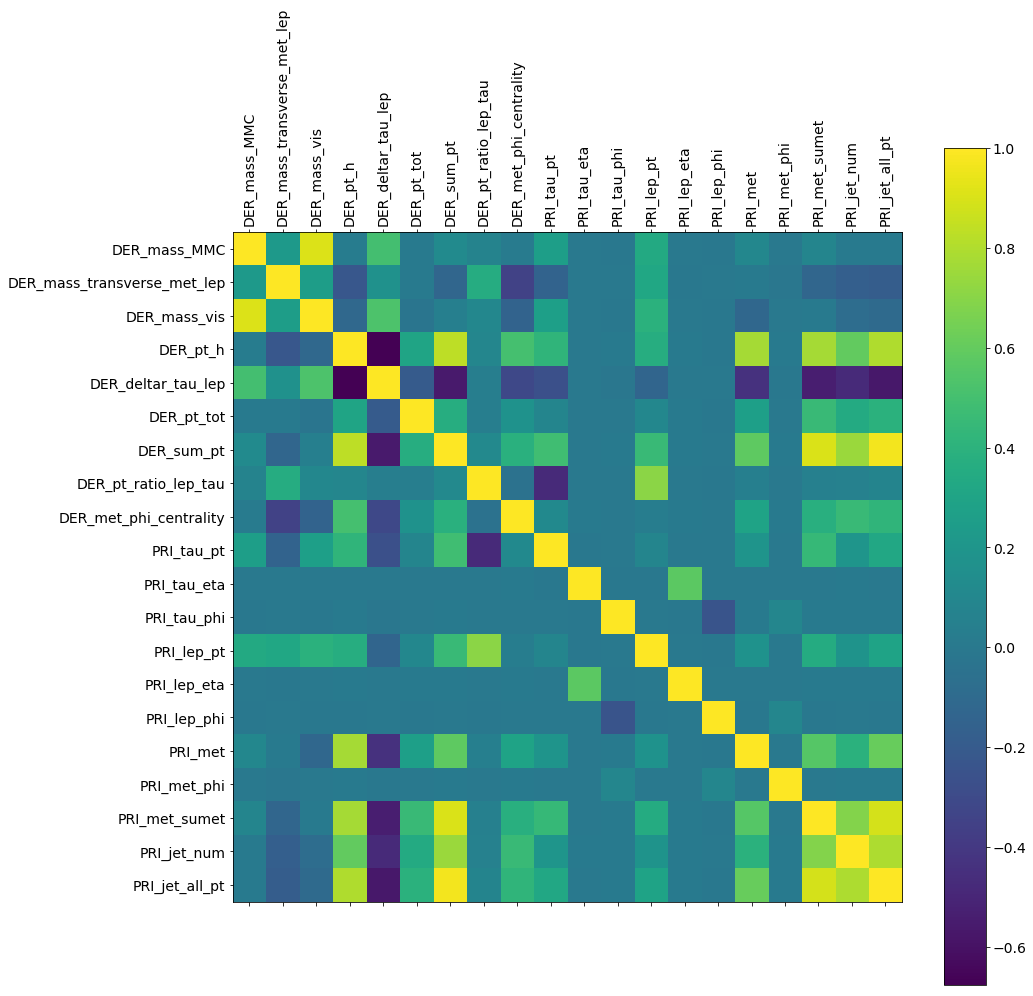

In [0]:
f = plt.figure(figsize=(15, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [0]:
pca=PCA(n_components=4) 
pca.fit(df) 
X_pca=pca.transform(df) 
pca.explained_variance_ratio_

array([0.79298548, 0.09185113, 0.037045  , 0.02759164])

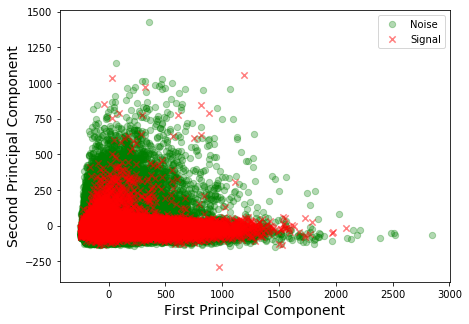

In [0]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels=data_dropped.Label
cdict={'s':'red','b':'green'}
labl={'s':'Signal','b':'Noise'}
marker={'s':'x','b':'o'}
alpha={'s':.5, 'b':.3}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix = np.where(labels==l)[0]
 ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()
# please check the scatter plot of the remaining component and you will understand the difference

In [0]:
from sklearn.decomposition.kernel_pca import KernelPCA

In [0]:
kpca = KernelPCA(n_components=3, kernel="rbf")
df_sample = df.sample(n= 10000, random_state=1)
X_kpca = kpca.fit_transform(df_sample)

print('Original number of features:', df.shape[1])
print('Reduced number of features:', X_kpca.shape[1])

Original number of features: 20
Reduced number of features: 3


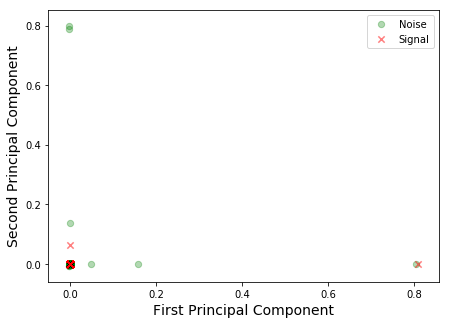

In [0]:
X_pca = X_kpca
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels= data_dropped.loc[df_sample.index].Label
cdict={'s':'red','b':'green'}
labl={'s':'Signal','b':'Noise'}
marker={'s':'x','b':'o'}
alpha={'s':.5, 'b':.3}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix = np.where(labels==l)[0]
 ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()

In [0]:
from sklearn.manifold import MDS
embedding = MDS(n_components=3)
df_sample = df.sample(n= 1000, random_state=1)
X_transformed = embedding.fit_transform(df_sample)

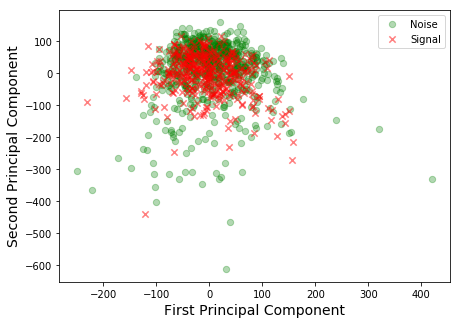

In [0]:
X_pca = X_transformed
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels= data_dropped.loc[df_sample.index].Label
cdict={'s':'red','b':'green'}
labl={'s':'Signal','b':'Noise'}
marker={'s':'x','b':'o'}
alpha={'s':.5, 'b':.3}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix = np.where(labels==l)[0]
 ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()

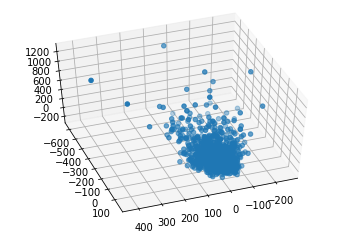

In [0]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X_transformed[:, 0], X_transformed[:, 1], X_transformed[:, 2])
ax.view_init(azim=70, elev=50)

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000)
tsne_results = tsne.fit_transform(df_sample)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 13.266745
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.150902
[t-SNE] KL divergence after 1000 iterations: 0.906616


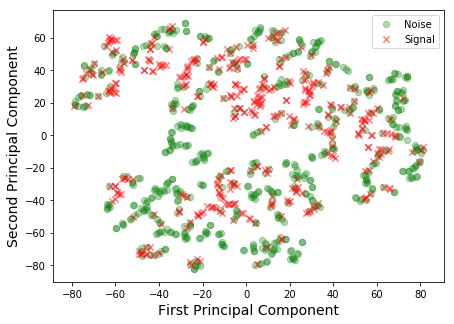

In [0]:
X_pca = tsne_results
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels= data_dropped.loc[df_sample.index].Label
cdict={'s':'red','b':'green'}
labl={'s':'Signal','b':'Noise'}
marker={'s':'x','b':'o'}
alpha={'s':.5, 'b':.3}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix = np.where(labels==l)[0]
 ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()